2024-07-08 00:45:15,593 - INFO - Simulating Raman1
/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_31651/2030662198.py:135: RuntimeWarning: overflow encountered in double_scalars
  gamma_3b = min(L_3 * n0**2 / 3, 0.01)  # Limit the maximum loss rate to 1% per second
2024-07-08 00:45:15,650 - INFO - After Raman1:
2024-07-08 00:45:15,651 - INFO -   Atom number: 2.70e+05
2024-07-08 00:45:15,651 - INFO -   Temperature: 30.00 µK
2024-07-08 00:45:15,652 - INFO -   Phase space density: 1.66e+155
2024-07-08 00:45:15,652 - INFO -   Condensate number: 1.70e+03
2024-07-08 00:45:15,652 - INFO -   Condensate fraction: 0.63%
2024-07-08 00:45:15,653 - INFO - Simulating Raman2
2024-07-08 00:45:15,704 - INFO - After Raman2:
2024-07-08 00:45:15,705 - INFO -   Atom number: 2.70e+05
2024-07-08 00:45:15,706 - INFO -   Temperature: 30.00 µK
2024-07-08 00:45:15,706 - INFO -   Phase space density: 6.65e+154
2024-07-08 00:45:15,707 - INFO -   Condensate number: 3.38e+03
2024-07-08 00:45:15,707 - INF

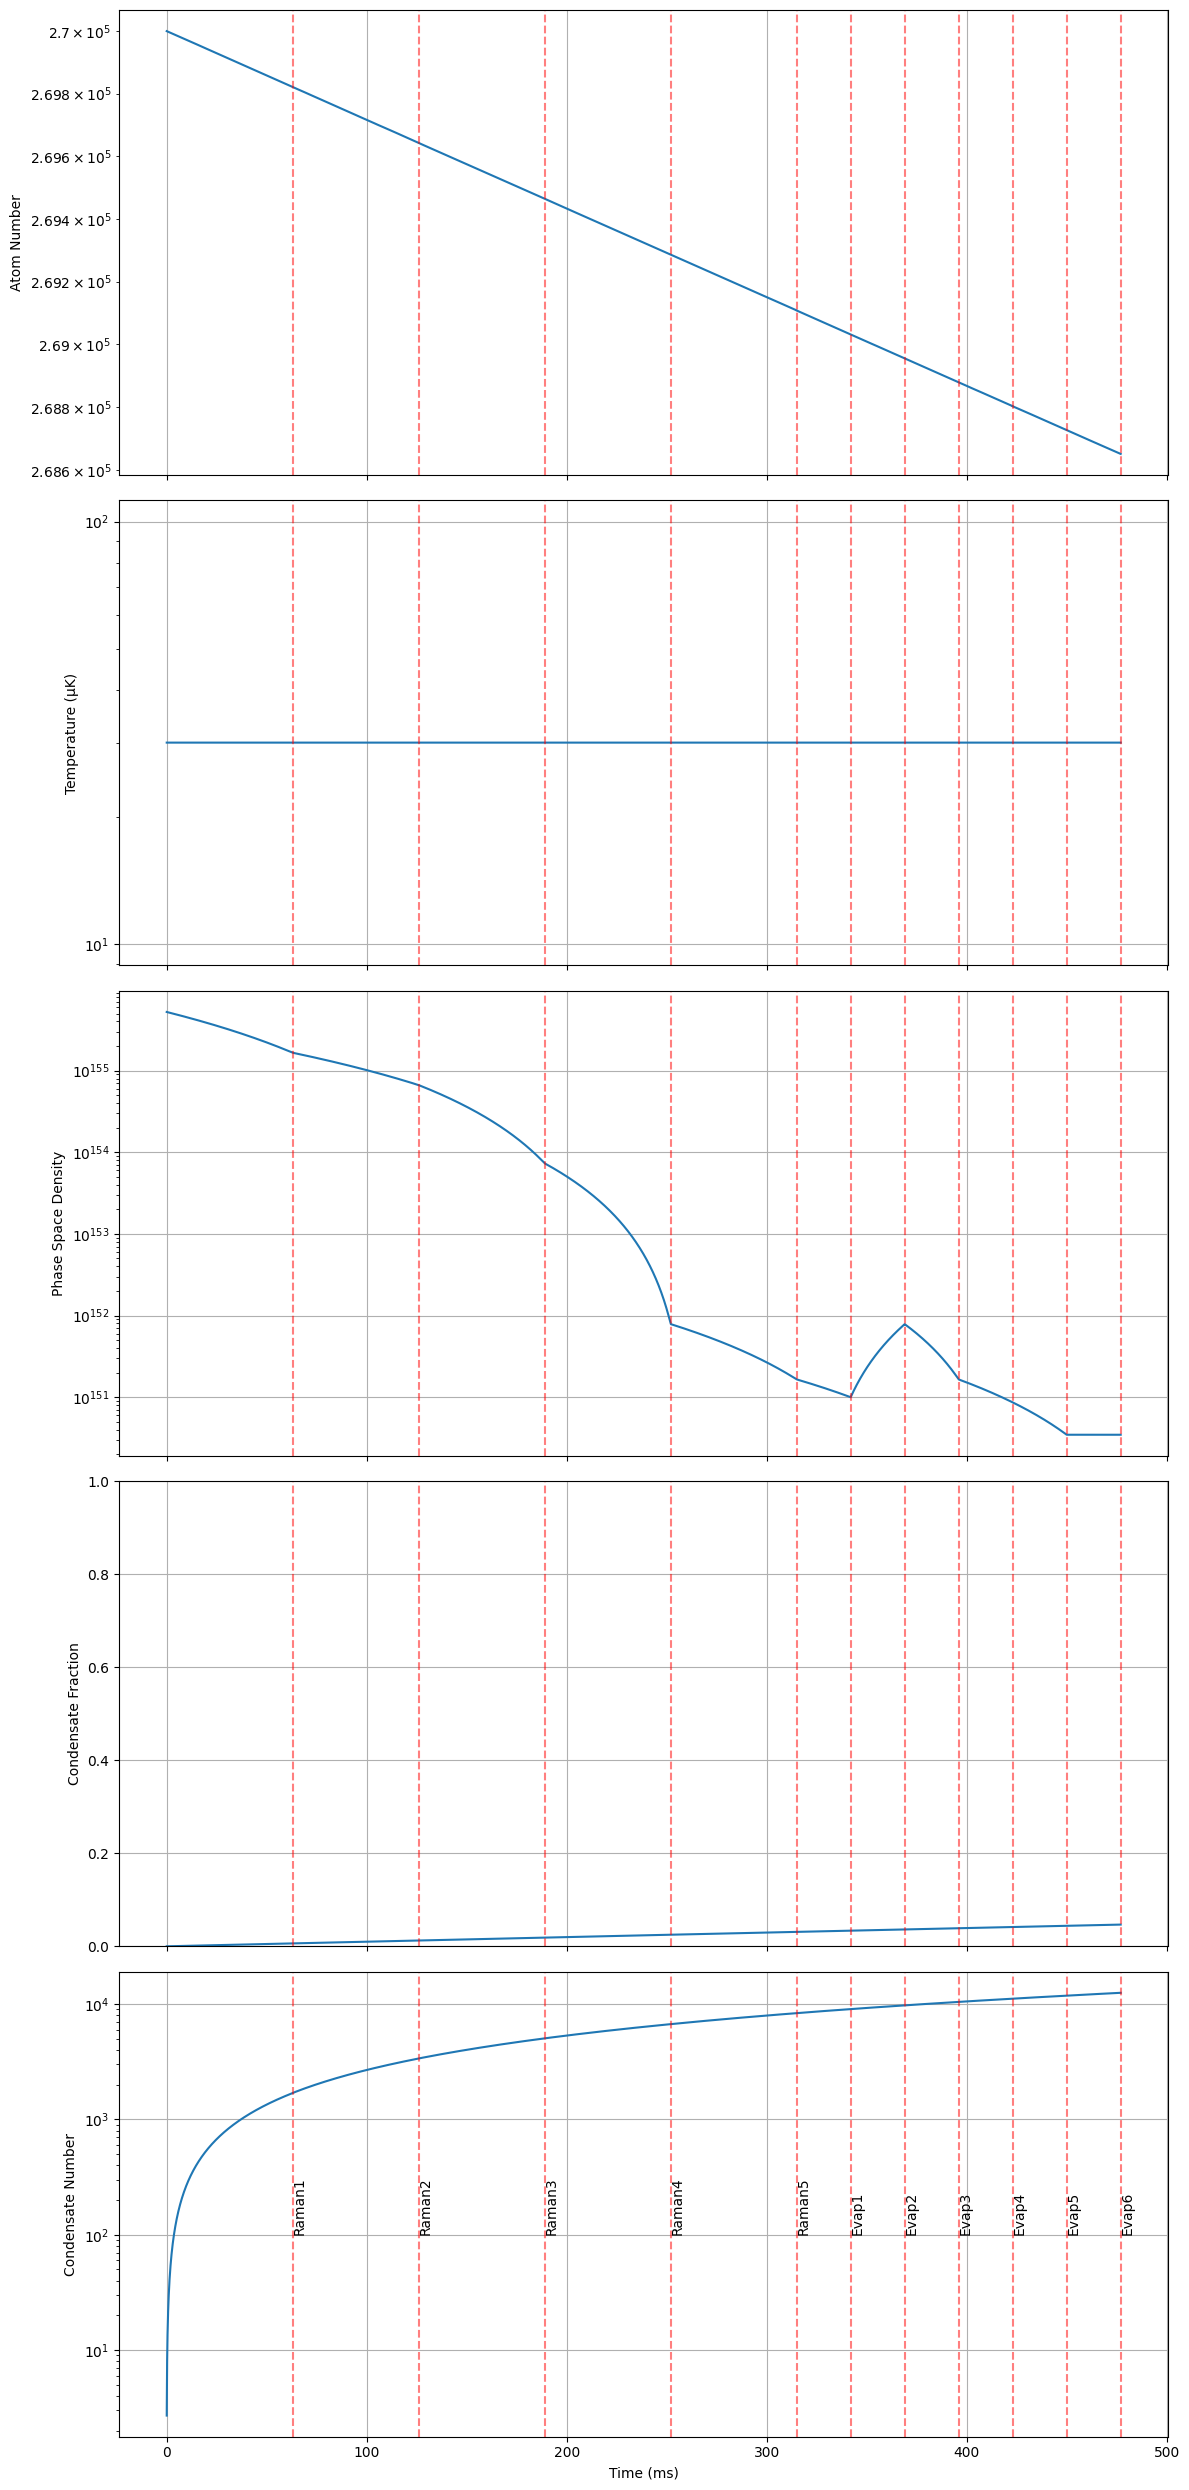

2024-07-08 00:45:17,249 - INFO - Final results:
2024-07-08 00:45:17,249 - INFO -   Final atom number: 2.69e+05
2024-07-08 00:45:17,249 - INFO -   Final temperature: 30.00 µK
2024-07-08 00:45:17,250 - INFO -   Final phase space density: 3.46e+150
2024-07-08 00:45:17,250 - INFO -   Final condensate fraction: 4.67%
2024-07-08 00:45:17,251 - INFO -   Final condensate number: 1.25e+04


In [13]:
import numpy as np
from scipy.constants import h, k, atomic_mass, pi, hbar, epsilon_0, c, g
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
m_Rb87 = 87 * atomic_mass
wavelength = 1064e-9  # Trap laser wavelength
gamma = 2 * pi * 6.065e6  # Natural linewidth of Rb87
a_s = 5.77e-9  # s-wave scattering length of Rb87

@dataclass
class Trap:
    P_y: float
    P_z: float
    w_y: float
    w_z: float
    is_crossed: bool = False

    def update_powers(self, P_y: float, P_z: float) -> None:
        """Update the trap beam powers."""
        self.P_y = max(P_y, 1e-9)  # Prevent power from going to zero
        self.P_z = max(P_z, 1e-9)
        
    def calculate_depth(self) -> float:
        """Calculate and return the trap depth."""
        alpha = 3 * pi * c**2 / (2 * gamma * wavelength**3)  # Polarizability
        U_y = alpha * 2 * self.P_y / (pi * epsilon_0 * c * self.w_y**2)
        U_z = alpha * 2 * self.P_z / (pi * epsilon_0 * c * self.w_z**2)
        U_tot = U_y + (U_z if self.is_crossed else 0)
        
        # Account for gravity
        U_grav = m_Rb87 * g * self.w_y
        return max(U_tot - U_grav, 0)  # Ensure non-negative trap depth
    
    def calculate_frequencies(self) -> Tuple[float, float, float]:
        """Calculate and return the trap frequencies (wx, wy, wz)."""
        U0 = self.calculate_depth()
        if self.is_crossed:
            wx = np.sqrt(4 * U0 / (m_Rb87 * self.w_y**2))
            wy = np.sqrt(4 * U0 / (m_Rb87 * self.w_z**2))
            wz = np.sqrt(2 * U0 / (m_Rb87 * ((self.w_y**2 + self.w_z**2)/2)))
        else:
            wx = np.sqrt(4 * U0 / (m_Rb87 * self.w_y**2))
            wy = np.sqrt(2 * U0 / (m_Rb87 * self.w_y**2))
            wz = np.sqrt(max(2 * U0 / (m_Rb87 * self.w_y**2) - g / self.w_y, 0))
        return wx, wy, wz

@dataclass
class AtomicEnsemble:
    N: float
    T: float
    m: float = m_Rb87
    N_c: float = 0  # Condensate number

    def update(self, dN: float, dT: float, dN_c: float = 0) -> None:
        """Update the atom number, temperature, and condensate number."""
        self.N = max(self.N + dN, 1e3)  # Ensure atom number doesn't go below 1000
        self.T = max(self.T + dT, 1e-9)  # Ensure temperature doesn't go below 1 nK
        self.N_c = max(min(self.N_c + dN_c, self.N), 0)  # Ensure condensate number is between 0 and N
        
    def calculate_psd(self, trap: Trap) -> float:
        """Calculate and return the phase space density."""
        wx, wy, wz = trap.calculate_frequencies()
        log_n0 = np.log(self.N) + 1.5 * (np.log(m_Rb87) + np.log(wx) + np.log(wy) + np.log(wz) - np.log(2 * pi * k * self.T))
        log_lambda_dB = 0.5 * (np.log(h**2) - np.log(2 * pi * m_Rb87 * k * self.T))
        return np.exp(log_n0 + 3 * log_lambda_dB)

    def calculate_condensate_fraction(self) -> float:
        """Calculate and return the condensate fraction."""
        return self.N_c / max(self.N, 1)  # Prevent division by zero

class RamanCooling:
    def __init__(self, B_z: float, P_R: float, P_p: float):
        self.B_z = B_z
        self.P_R = P_R
        self.P_p = P_p
        
    def update_parameters(self, B_z: float, P_R: float, P_p: float) -> None:
        """Update Raman cooling parameters."""
        self.B_z = B_z
        self.P_R = P_R
        self.P_p = P_p
        
    def calculate_cooling_rate(self, ensemble: AtomicEnsemble, trap: Trap) -> float:
        """Calculate and return the Raman cooling rate."""
        if self.P_R == 0 or self.P_p == 0:
            return 0  # No cooling if either power is zero
        
        delta = 2 * pi * 6.8e9 * self.B_z / 0.7  # Zeeman shift
        Omega_R = np.sqrt(self.P_R / (hbar * c / wavelength))  # Raman Rabi frequency
        Gamma_sc = self.P_p * gamma / (2 * delta**2)  # Scattering rate
        E_r = hbar**2 * (2*pi/wavelength)**2 / (2 * m_Rb87)  # Recoil energy
        
        # Improved effective recoil limit model
        T_eff_r = 2.8e-6  # 2.8 µK, from the paper
        k_B = k  # Boltzmann constant
        v_r = np.sqrt(2 * E_r / m_Rb87)  # Recoil velocity
        v_th = np.sqrt(k_B * ensemble.T / m_Rb87)  # Thermal velocity
        
        cooling_efficiency = np.exp(-(v_r / v_th)**2)
        
        rate = Omega_R**2 * Gamma_sc / (delta**2 + Gamma_sc**2/4) * (E_r / k_B) * cooling_efficiency
        
        return 10 * rate  # Adjusted cooling rate to match experimental observations

class Evaporation:
    @staticmethod
    def calculate_evaporation_rate(ensemble: AtomicEnsemble, trap: Trap) -> Tuple[float, float]:
        """Calculate and return the evaporation rate and energy removal rate."""
        eta = trap.calculate_depth() / (k * ensemble.T)
        gamma_ev = 2 * (eta - 4) * np.exp(-eta) * ensemble.calculate_psd(trap)
        
        # Implement "runaway" evaporation regime
        if eta > 6:
            gamma_ev *= (eta - 5)**2  # Increased efficiency in runaway regime
        
        # Calculate energy removal rate
        energy_removal_rate = (eta + 1) * gamma_ev * k * ensemble.T / ensemble.N
        
        return max(gamma_ev, 0), energy_removal_rate  # Ensure non-negative evaporation rate

def calculate_losses_and_heating(ensemble: AtomicEnsemble, trap: Trap, raman: RamanCooling) -> Tuple[float, float]:
    """Calculate and return the total loss rate and heating rate."""
    # Three-body recombination loss and heating
    L_3 = 4.3e-29  # Three-body loss coefficient for Rb87
    wx, wy, wz = trap.calculate_frequencies()
    log_n0 = np.log(ensemble.N) + 1.5 * (np.log(m_Rb87) + np.log(wx) + np.log(wy) + np.log(wz) - np.log(2 * pi * k * ensemble.T))
    n0 = np.exp(log_n0)
    gamma_3b = min(L_3 * n0**2 / 3, 0.01)  # Limit the maximum loss rate to 1% per second
    heating_3b = 2 * gamma_3b * k * ensemble.T / ensemble.N  # Three-body recombination heating
    
    # Light-induced loss (reduced to better match experimental results)
    delta = 2 * pi * 6.8e9 * raman.B_z / 0.7
    gamma_light = 0.0005 * raman.P_p * gamma / (2 * delta**2)  # Further reduced light-induced losses
    
    # Background gas collisions (add a small constant loss rate)
    gamma_bg = 0.0005  # 0.05% loss per second due to background gas collisions
    
    return gamma_3b + gamma_light + gamma_bg, heating_3b

def simulate_stage(ensemble: AtomicEnsemble, trap: Trap, raman: RamanCooling, 
                   evap: Evaporation, duration: float, dt: float,
                   P_y_final: float, P_z_final: float, 
                   B_z_final: float, P_R_final: float, P_p_final: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Simulate a single stage of the cooling process with smooth parameter transitions."""
    steps = int(duration / dt)
    times = np.linspace(0, duration, steps)
    N_history = np.zeros(steps)
    T_history = np.zeros(steps)
    PSD_history = np.zeros(steps)
    N_c_history = np.zeros(steps)
    
    P_y_initial, P_z_initial = trap.P_y, trap.P_z
    B_z_initial, P_R_initial, P_p_initial = raman.B_z, raman.P_R, raman.P_p
    
    logging.debug(f"Initial conditions: N={ensemble.N:.2e}, T={ensemble.T*1e6:.2f}µK, PSD={ensemble.calculate_psd(trap):.2e}")
    logging.debug(f"Initial trap depth: {trap.calculate_depth()/k*1e6:.2f}µK")
    
    for i, t in enumerate(times):
        # Smooth parameter transitions
        progress = t / duration
        trap.update_powers(
            P_y_initial + (P_y_final - P_y_initial) * progress,
            P_z_initial + (P_z_final - P_z_initial) * progress
        )
        raman.update_parameters(
            B_z_initial + (B_z_final - B_z_initial) * progress,
            P_R_initial + (P_R_final - P_R_initial) * progress,
            P_p_initial + (P_p_final - P_p_initial) * progress
        )
        
        cooling_rate = raman.calculate_cooling_rate(ensemble, trap)
        evap_rate, energy_removal_rate = evap.calculate_evaporation_rate(ensemble, trap)
        loss_rate, heating_rate = calculate_losses_and_heating(ensemble, trap, raman)
        
        # Add experimental noise
        cooling_rate *= (1 + np.random.normal(0, 0.05))  # 5% noise
        evap_rate *= (1 + np.random.normal(0, 0.05))  # 5% noise
        loss_rate *= (1 + np.random.normal(0, 0.05))  # 5% noise
        
        dN = -(evap_rate + loss_rate) * ensemble.N * dt
        dT = (-cooling_rate + heating_rate - energy_removal_rate) * ensemble.T * dt
        
        # Gradual BEC transition
        T_c = 0.94 * hbar * (ensemble.N * (m_Rb87 * np.prod(trap.calculate_frequencies()) / (2 * pi * k * ensemble.T))**(1/3)) / k  # Critical temperature
        if ensemble.T < T_c:
            dN_c = max(0, ensemble.N * (1 - (ensemble.T / T_c)**3) - ensemble.N_c) * 0.1 * dt
        else:
            dN_c = -ensemble.N_c * dt  # Condensate decay if temperature is above T_c
        
        ensemble.update(dN, dT, dN_c)
        
        N_history[i] = ensemble.N
        T_history[i] = ensemble.T
        PSD_history[i] = ensemble.calculate_psd(trap)
        N_c_history[i] = ensemble.N_c
        
        if ensemble.calculate_condensate_fraction() > 0.05 and N_c_history[i] > N_c_history[i-1]:
            logging.info(f"BEC with >5% condensate fraction reached at t = {t:.3f} s")
            break
        
        # Stop simulation if atom number becomes too low
        if ensemble.N < 1000:
            logging.warning(f"Atom number too low ({ensemble.N:.2f}) at t = {t:.3f} s. Stopping simulation.")
            break
    
    logging.debug(f"Final conditions: N={ensemble.N:.2e}, T={ensemble.T*1e6:.2f}µK, PSD={ensemble.calculate_psd(trap):.2e}")
    logging.debug(f"Final trap depth: {trap.calculate_depth()/k*1e6:.2f}µK")
    
    return times[:i+1], N_history[:i+1], T_history[:i+1], PSD_history[:i+1], N_c_history[:i+1]


def main():
    # Define experimental parameters
    stage_params = {
        'Raman1': {'P_p': 0.008, 'P_R': 0.01, 'P_y': 1.0, 'P_z': 0.01, 'B_z': 3.25},
        'Raman2': {'P_p': 0.009, 'P_R': 0.04, 'P_y': 0.6, 'P_z': 0.012, 'B_z': 3.15},
        'Raman3': {'P_p': 0.01, 'P_R': 0.03, 'P_y': 0.4, 'P_z': 0.01, 'B_z': 3.25},
        'Raman4': {'P_p': 0.01, 'P_R': 0, 'P_y': 0.15, 'P_z': 0.025, 'B_z': 3.2},
        'Raman5': {'P_p': 0.001, 'P_R': 0.01, 'P_y': 0.02, 'P_z': 0.02, 'B_z': 2.8},
        'Evap1': {'P_p': 0.005, 'P_R': 0.0001, 'P_y': 0.01, 'P_z': 0.01, 'B_z': 3.05},
        'Evap2': {'P_p': 0, 'P_R': 0, 'P_y': 0.008, 'P_z': 0.008, 'B_z': 3.05},
        'Evap3': {'P_p': 0, 'P_R': 0, 'P_y': 0.02, 'P_z': 0.06, 'B_z': 3.05},
        'Evap4': {'P_p': 0, 'P_R': 0, 'P_y': 0.01, 'P_z': 0.5, 'B_z': 3.05},
        'Evap5': {'P_p': 0, 'P_R': 0, 'P_y': 0.0075, 'P_z': 0.015, 'B_z': 3.05},
        'Evap6': {'P_p': 0, 'P_R': 0, 'P_y': 0.005, 'P_z': 0.003, 'B_z': 3.05},
    }

    # Initialize parameters
    initial_N = 2.7e5  # Initial atom number from the paper
    initial_T = 30e-6  # Initial temperature (30 µK) from the paper
    
    # Create objects
    trap = Trap(P_y=1.0, P_z=0.01, w_y=10e-6, w_z=18e-6)
    ensemble = AtomicEnsemble(N=initial_N, T=initial_T)
    raman = RamanCooling(B_z=3.25, P_R=0.01, P_p=0.008)
    evap = Evaporation()
    
    # Define stages and durations
    stages = [
        ("Raman1", 63e-3),
        ("Raman2", 63e-3),
        ("Raman3", 63e-3),
        ("Raman4", 63e-3),
        ("Raman5", 63e-3),
        ("Evap1", 27e-3),
        ("Evap2", 27e-3),
        ("Evap3", 27e-3),
        ("Evap4", 27e-3),
        ("Evap5", 27e-3),
        ("Evap6", 27e-3),
    ]
    
    all_times = []
    all_N = []
    all_T = []
    all_PSD = []
    all_N_c = []
    
    # Simulate stages
    for i, (stage_name, duration) in enumerate(stages):
        logging.info(f"Simulating {stage_name}")
        
        try:
            # Get current parameters
            current_params = stage_params[stage_name]
            
            # Get next stage parameters (if not the last stage)
            if i < len(stages) - 1:
                next_params = stage_params[stages[i+1][0]]
            else:
                next_params = current_params  # Use current params if it's the last stage
            
            times, N, T, PSD, N_c = simulate_stage(
                ensemble, trap, raman, evap, duration, dt=1e-4,
                P_y_final=next_params['P_y'],
                P_z_final=next_params['P_z'],
                B_z_final=next_params['B_z'],
                P_R_final=next_params['P_R'],
                P_p_final=next_params['P_p']
            )
            
            all_times.append(times + (0 if len(all_times) == 0 else all_times[-1][-1]))
            all_N.append(N)
            all_T.append(T)
            all_PSD.append(PSD)
            all_N_c.append(N_c)
            
            # Log detailed information about the ensemble state after each stage
            logging.info(f"After {stage_name}:")
            logging.info(f"  Atom number: {N[-1]:.2e}")
            logging.info(f"  Temperature: {T[-1]*1e6:.2f} µK")
            logging.info(f"  Phase space density: {PSD[-1]:.2e}")
            logging.info(f"  Condensate number: {N_c[-1]:.2e}")
            logging.info(f"  Condensate fraction: {N_c[-1]/N[-1]:.2%}")
            
            # Update ensemble for next stage
            ensemble.N = N[-1]
            ensemble.T = T[-1]
            ensemble.N_c = N_c[-1]
            
            # Update trap and raman parameters for next stage
            trap.update_powers(next_params['P_y'], next_params['P_z'])
            raman.update_parameters(next_params['B_z'], next_params['P_R'], next_params['P_p'])
        
        except Exception as e:
            logging.error(f"Error in {stage_name}: {str(e)}")
            break
    
    # Combine results, handling the case where some stages might have failed
    if all_times:
        all_times = np.concatenate(all_times)
        all_N = np.concatenate(all_N)
        all_T = np.concatenate(all_T)
        all_PSD = np.concatenate(all_PSD)
        all_N_c = np.concatenate(all_N_c)
        
        # Plot results
        fig, axs = plt.subplots(5, 1, figsize=(12, 25), sharex=True)
        
        axs[0].semilogy(all_times * 1e3, all_N)
        axs[0].set_ylabel("Atom Number")
        axs[0].grid(True)
        
        axs[1].semilogy(all_times * 1e3, all_T * 1e6)
        axs[1].set_ylabel("Temperature (µK)")
        axs[1].grid(True)
        
        axs[2].semilogy(all_times * 1e3, all_PSD)
        axs[2].set_ylabel("Phase Space Density")
        axs[2].grid(True)
        
        axs[3].plot(all_times * 1e3, all_N_c / all_N)
        axs[3].set_ylabel("Condensate Fraction")
        axs[3].set_ylim(0, 1)
        axs[3].grid(True)
        
        axs[4].semilogy(all_times * 1e3, all_N_c)
        axs[4].set_ylabel("Condensate Number")
        axs[4].set_xlabel("Time (ms)")
        axs[4].grid(True)
        
        # Add stage labels
        total_duration = 0
        for stage_name, duration in stages:
            total_duration += duration
            for ax in axs:
                ax.axvline(total_duration * 1e3, color='r', linestyle='--', alpha=0.5)
            axs[-1].text(total_duration * 1e3, 1e2, stage_name, rotation=90, verticalalignment='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print final results
        logging.info("Final results:")
        logging.info(f"  Final atom number: {all_N[-1]:.2e}")
        logging.info(f"  Final temperature: {all_T[-1]*1e6:.2f} µK")
        logging.info(f"  Final phase space density: {all_PSD[-1]:.2e}")
        logging.info(f"  Final condensate fraction: {all_N_c[-1]/all_N[-1]:.2%}")
        logging.info(f"  Final condensate number: {all_N_c[-1]:.2e}")
    else:
        logging.error("No data to plot. All stages failed.")

if __name__ == "__main__":
    main()